In [264]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [232]:
df = pd.read_csv(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date']).sort_index()
df = df[['Close']]
df.head(5)

,Close
Date,
1990-01-01,329.079987
1990-02-01,331.890015
1990-03-01,339.940002
1990-04-01,330.799988
1990-05-01,361.230011


In [238]:
df.sort_index(inplace=True)
temp = df.copy(deep=True)
temp['Close_1'] = df['Close']
temp['Close_2'] = df['Close'].shift(-1)
temp['Close_3'] = df['Close'].shift(-2)
temp['Close'] = temp['Close'].shift(-3)
temp.dropna(inplace=True)
print(len(temp))
temp.head(5)

410


,Close,Close_1,Close_2,Close_3
Date,,,,
1990-01-01,330.799988,329.079987,331.890015,339.940002
1990-02-01,361.230011,331.890015,339.940002,330.799988
1990-03-01,358.019989,339.940002,330.799988,361.230011
1990-04-01,356.149994,330.799988,361.230011,358.019989
1990-05-01,322.559998,361.230011,358.019989,356.149994


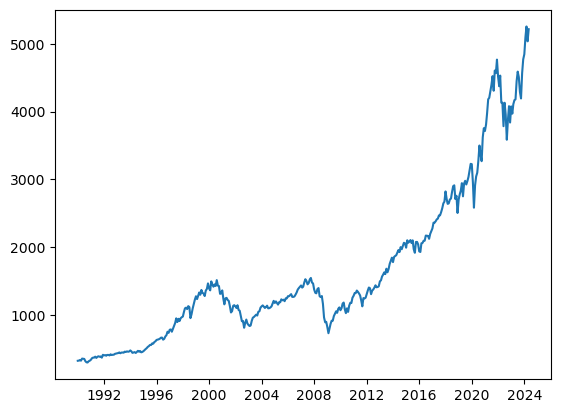

In [213]:
plt.plot(df.index,df.Close)
plt.show()

# Designing ANN Model

In [215]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [237]:
class Model(nn.Module):
    def __init__(self, in_features=3, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 60)
        self.fc2 = nn.Linear(60, 60)
        self.out = nn.Linear(60,out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x
    
    def predict(self, test):
        with torch.no_grad():
            y_eval = self.forward(test)
            return y_eval



In [242]:
X = temp[['Close_1','Close_2','Close_3']]
y = temp['Close']

In [243]:
X = X.to_numpy()
y = y.to_numpy()

In [245]:
len(temp) * 0.8

328.0

In [246]:
X_train = X[:328]
y_train = y[:328]
X_test = X[328:]
y_test = y[328:]

In [247]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

y_train = y_train.float()
y_test = y_test.float()

In [248]:
torch.manual_seed(41)
model = Model()
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [249]:
epochs = 100
losses = []
for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train.unsqueeze(1))
    losses.append(loss.detach().numpy())
    if i % 10 == 0:
        print(f'Epoch: {i} and loss: {loss}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 and loss: 1769075.125
Epoch: 10 and loss: 37850.65234375
Epoch: 20 and loss: 36062.75
Epoch: 30 and loss: 19950.27734375
Epoch: 40 and loss: 6548.24462890625
Epoch: 50 and loss: 3144.834716796875
Epoch: 60 and loss: 3754.368896484375
Epoch: 70 and loss: 3269.63720703125
Epoch: 80 and loss: 3108.00390625
Epoch: 90 and loss: 3085.20947265625


Text(0.5, 0, 'Epoch')

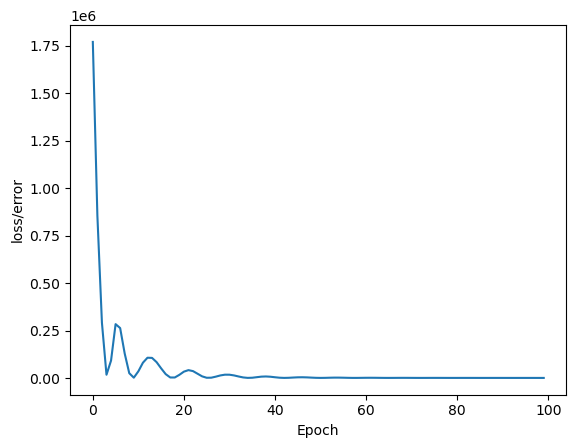

In [250]:
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')

In [258]:
y_eval = model.predict(X_test)
print(len(y_eval),len(y_test))

82 82


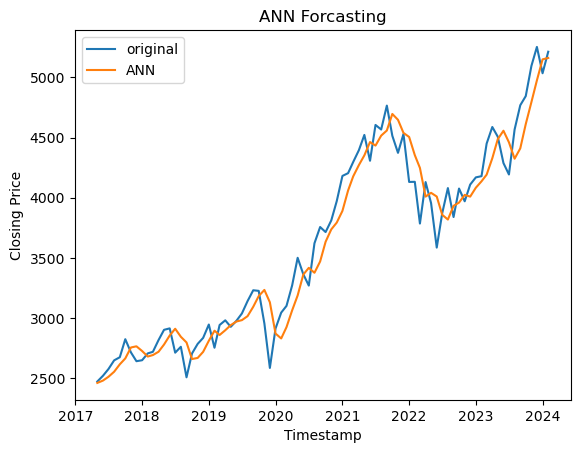

In [263]:
plt.plot(temp[328:].index,y_test,label="original")
plt.plot(temp[328:].index,y_eval,label='ANN')
plt.xlabel('Timestamp')
plt.ylabel('Closing Price')
plt.title('ANN Forcasting')
plt.legend()
plt.show()

In [267]:
mean_squared_error(y_test, y_eval)

35948.203

In [268]:
torch.save(model.state_dict(), r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\ANN.pt')